# 인물사진 만들기

### 셸로우 포커스 만들기(1) 사진을 준비하자

#### 하나의 카메라로 셸로우 포커스 (shallow focus)를 만드는 방법

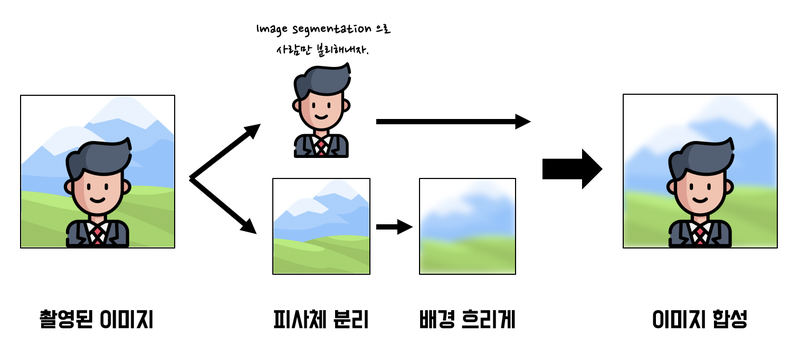

두 개의 렌즈가 맡은 역활은 하나의 렌즈에서 구현해야 한다. 이미지 세그멘테이션(image segmantation) 기술을 이용하면 이미지에서 배경과 사람을 분리할 수 있다. 분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 적용한 인물 사진을 얻을 수 있다.

따라서 우리는 다음과 같은 후가공으로 '인물사진 모드'인 사진을 만들 거다.

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


urlib는 웹에서 데이터를 다운로드할 때 사용한다.
cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요하다.
pixelib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리이다. 아직 시맨틱 세그멘테이션 모델을 직접만들기에는 어려우니 준비된 모델을 사용만 해보겠다.
이제 라이브러리에 대해 이해가 되었으니 시작해보자.

(500, 892, 3)


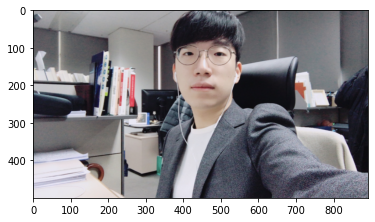

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기

배경에만 렌즈 흐림 효과를 주기 위해서 그림과 같이 이미지에서 사람과 피사체를 분리해야 한다. 흔히 포토샵으로 '누가 따기'라는 것이 바로 이런 작업을 말한다. 인물 사진에서 배경만 다르게 편집하려는 용도로 흔히 하는 작업이다.

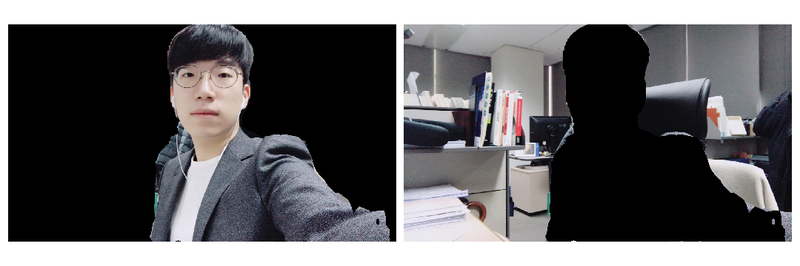

#### 세그멘테이션(Segmentation)이 뭔가요 ?

이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation)이라고 한다. 이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정한다. 이때 공통 특징은 물리적 의미가 없을 수도 있다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이죠. 물론 세그멘테이션에는 여러 가지 세부 테스크가 있으며, 테스크에 따라 다양한 기준으로 객체를 추출한다.

#### 시맨틱 세그멘테이션(semantic segmentation)이란 ?

세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션이라고 한다. 쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해하면 된다. 오늘 다룰 세그멘테이션 방법이기도 한다.

#### 인스턴스 세그멘테이션(Instance segmentation)이란 ?

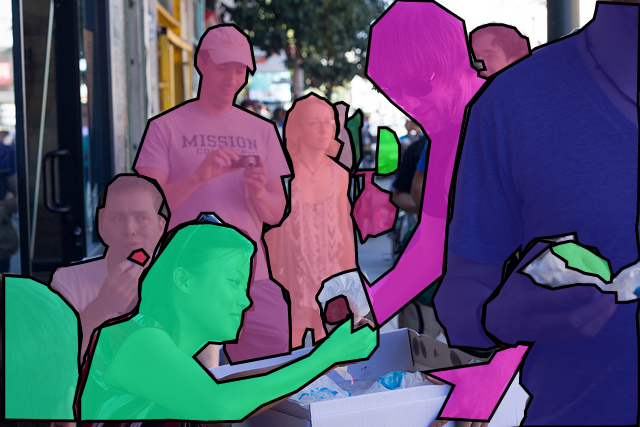

시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해 내는 방법이다. 그래서 사람이 누구인지 관계없이 같은 라벨로 표현이 된다.
더 나아가서 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨을 가지게 한다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표이다.

### 셸로우 포커스 만들기(3) 시맨틱 세그멘테이션 다뤄보기

본격적으로 세그멘테이션을 다루어 보겠다. 세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용된다. 오늘은 그 중에서 DeepLab이라는 세그멘테이션 모델을 이용해 볼 거다. DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지 많이 사용되고 있다.

이제, DeepLab 모델을 준비해보겠다. 아까 준비한 PixelLib를 이용하면 편하게 사용할 수 있다.

먼저 PixelLib에서 제공해 주는 모델을 다운로드 한다.

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fa737868250>)

그다음 다운로드한 모델을 이용해 PixellLib로 우리가 사용할 세그멘테이션 모델을 생성한다.

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

이제 모델에 이미지를 입력해 보겠다.

In [6]:
segvalues, output = model.segmentAsPascalvoc(img_path)

segmentASPascalvoc라는 함수 이름에서 세그멘테이션 모델에 대한 힌트를 얻을 수 있다. PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미이다. 모델마다 학습시킨 데이터에 따라 결과값이 달라지므로 어떤 데이터를 학습시켰는지 확인하는 것이 매우 중요하다.

PASCAL VOC 데이터의 라벨 종류는 아래와 같다.

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있다. 따라서 20의 의미는 tv가 되겠다. 0부터 시작하니깐 !
우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶다. 이제 사람만 어떻게 추출할 수 있을지 알아보자.
아까 모델에서 나온 출력값을 살짝 살펴보자.

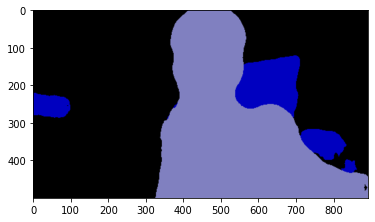

In [8]:
plt.imshow(output)
plt.show()

In [9]:
segvalues

{'class_ids': array([ 0,  9, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]])}

In [10]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


output에는 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있다. segvalues에는 class_ids와 masks가 있다. class_ids를 통해 어떤 물체가 담겨 있는 지 알 수 있다.

이는 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내면 될 것이다.

In [11]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

PixelLib에 따르면 위와 같은 색을 사용했다고 하네요. 그럼 사람을 나타내는 15번째 색상은 무엇일까?

In [12]:
colormap[15]

array([192, 128, 128])

사람 외에도 다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 찾아낼 수 있다. 여기서 주의할 것은 output 이미지가 BGR 순서로 채널 배치가 되어 있다는 점이다. colormap은 RGB 순서이다. 그러니 우리가 추출해야 하는 색상 값은 순서를 아래처럼 바꿔줘야 한다.

In [13]:
seg_color = (128,128,192)

이제 seg_color로만 이루어진 마스크를 만들어 보자.

3채널 가졌던 원본과는 다르게 채널 정보가 사라졌다.

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 되었다.

원래 이미지와 겹쳐 보면 세그멘테이션이 얼마나 잘 되었는지 알아보기 쉬울 것이다.

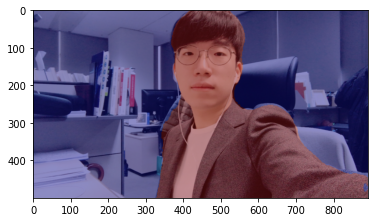

In [15]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 9-5 셸로우 포커스 만들기 (4) 배경 흐리게 하기

이번에는 배경을 흐리게 만든다. blur() 함수를 이용한다.

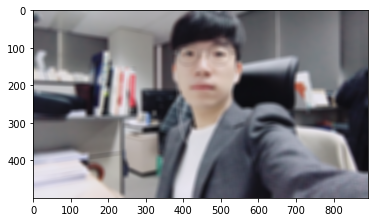

In [16]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠다.

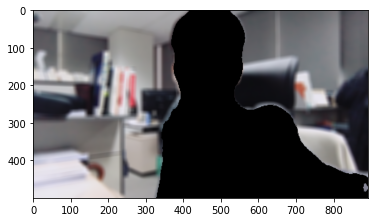

In [17]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전된다. 원래 마스크에서는 배경이 0, 사람이 255였으니 bitwise_not 연산을 하고 나면 배경은 255, 사람은 0이 된다.

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있다. 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이된다. 결국 사람이 사라지게 되는 거다.

### 셸로우 포커스 만들기 (5) 흐린 배경과 원본 영상 합성

이제 배경 영상과 사람 영상을 합치기만 하면 된다.

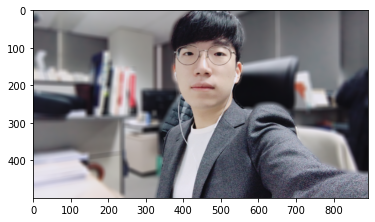

In [18]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용한다. np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용했다.

이로써 인물모드가 완성되었다. 원본과 비교해보자.

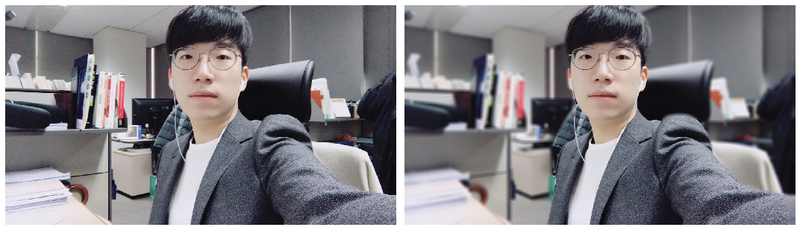

인물과 배경의 거리 차이가 있고 거리가 일정할 수록 더 자연스러워 보인다.